# Cell 1: Import Libraries

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.model_selection import train_test_split
import numpy as np
import time
import timm

# Cell 2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
pip install timm


# Cell 3: Data Preparation


In [ ]:
def prepare_data_loaders(sketches_path, batch_size):
    image_size = 224  # Typical input size for ViT models
    transform = Compose([
        Resize((image_size, image_size)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load dataset
    full_dataset = ImageFolder(root=sketches_path, transform=transform)

    # Get labels for stratified splitting
    labels = [label for _, label in full_dataset.samples]

    # Stratified Splitting into train, val, and test
    train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=0.2, random_state=42, stratify=labels)
    test_idx, val_idx = train_test_split(test_idx, test_size=0.5, random_state=42, stratify=[labels[i] for i in test_idx])


    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)
    test_dataset = Subset(full_dataset, test_idx)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, full_dataset.classes

# Cell 4: Loading the Model
# And Training, Validation and Testing Funciton

In [ ]:
class CustomViTModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomViTModel, self).__init__()
        self.model = timm.create_model('vit_large_patch32_224.orig_in21k', pretrained=True)
        self.model.head = nn.Linear(self.model.embed_dim, num_classes)
    def forward(self, x):
        x = self.model(x)
        return x

def train_func(model, train_loader, optimizer, criterion, device):
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predictions = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    epoch_loss = training_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            validation_loss += criterion(outputs, labels).item() * inputs.size(0)
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    validation_loss /= len(val_loader.dataset)
    validation_accuracy = 100. * correct / total
    return validation_loss, validation_accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            predictions = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

# Cell 5: Training and Testing Loop

In [ ]:
# Usage:
batch_size = 32
sketches_path = '/content/drive/My Drive/updated_png'
train_loader, val_loader, test_loader, classes = prepare_data_loaders(sketches_path, batch_size)
num_classes = len(classes)
model = CustomViTModel(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function for the classifier
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

epochs = 10

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print("Starting training...")
total_start_time = time.time()  # Start timing before the training loop

# Training and validation loop?
for epoch in range(epochs):
    train_loss, train_accuracy = train_func(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

total_end_time = time.time()  # End timing after the loop
total_duration = (total_end_time - total_start_time)/60
print(f"Total Running Time: {total_duration:.2f} minutes")

# Testing
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Cell 6: Calculating Top-5 Accuracy

In [ ]:
import torch
import numpy as np
from sklearn.metrics import top_k_accuracy_score

def evaluate_model_with_sklearn_top_k(model, device, test_loader, classes, k=5):
    """
    Evaluates the model on the test set using scikit-learn's top_k_accuracy_score.
    Returns:
    - None, prints the average Top-K accuracy.
    """
    model.eval()  # Ensure the model is in evaluation mode
    true_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Softmax to convert model logits to probabilities
            probabilities = torch.softmax(outputs, dim=1)
            all_scores.extend(probabilities.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    true_labels = np.array(true_labels)
    all_scores = np.array(all_scores)  # Shape: (n_samples, n_classes)

    # Ensure the labels parameter is correctly handled
    labels = np.arange(len(classes))  # Assuming classes correspond to [0, num_classes-1]

    top_k_accuracy = top_k_accuracy_score(true_labels, all_scores, k=k, labels=labels)
    print(f"Top-{k} Accuracy on Test Set: {top_k_accuracy * 100:.2f}%")


evaluate_model_with_sklearn_top_k(model, device, test_loader, classes, k=5)


# Cell 7: Plotting Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

def get_class_names(folder_path):
    """
    Returns a list of class names, where each class name is the name of a folder
    containing images of that class.
    """
    # List directories only
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    class_names.sort()  # Optional: sort the class names alphabetically
    return class_names

folder_path = '/content/drive/My Drive/updated_png'
class_names = get_class_names(folder_path)
print(class_names)


def plot_confusion_matrix(model, device, data_loader, class_names):
    """
    Generates and plots a confusion matrix and prints classification metrics for the given data.
    """
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            true_labels.extend(target.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Compute the confusion matrix
    conf_mat = confusion_matrix(true_labels, pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix of ViT-L/32')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(model, device, test_loader, class_names)


# Cell 8: Plotting Accuracy and Loss

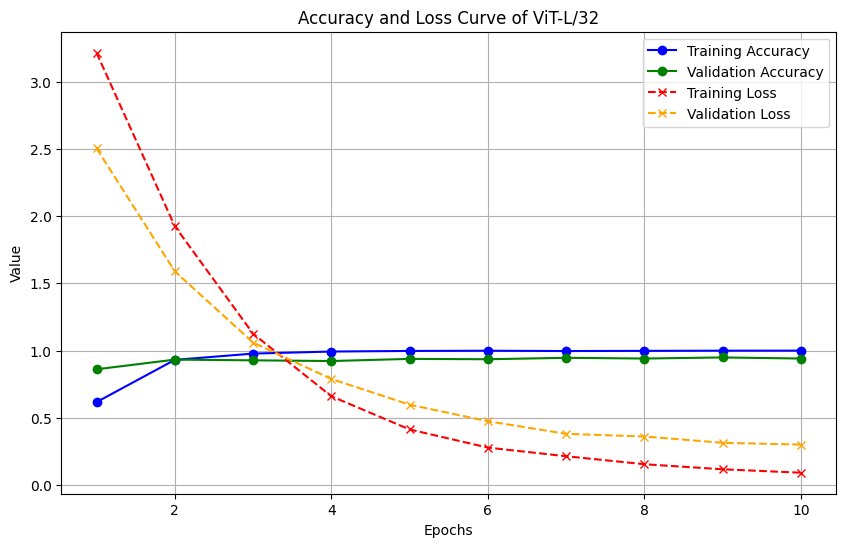

In [ ]:
import matplotlib.pyplot as plt

# Extracted data
train_accuracies = [61.73, 93.13, 97.80, 99.33, 99.77, 99.93, 99.70, 99.83, 99.97, 100.00]
val_accuracies = [86.13, 93.33, 92.80, 92.27, 93.87, 93.60, 94.67, 94.13, 94.93, 94.13]
train_losses = [3.2142, 1.9250, 1.1258, 0.6609, 0.4141, 0.2793, 0.2151, 0.1557, 0.1181, 0.0926]
val_losses = [2.5037, 1.5896, 1.0602, 0.7895, 0.5982, 0.4753, 0.3816, 0.3618, 0.3150, 0.3016]

# Define the function to plot learning curves
def plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)

    # Normalize accuracies to be on the same scale as losses
    train_accuracies = [x / 100 for x in train_accuracies]
    val_accuracies = [x / 100 for x in val_accuracies]

    plt.figure(figsize=(10, 6))

    # Plot training and validation accuracy
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')

    # Plot training and validation loss
    plt.plot(epochs, train_losses, label='Training Loss', color='red', linestyle='--', marker='x')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x')

    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Accuracy and Loss Curve of ViT-L/32')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function with the extracted data
plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)


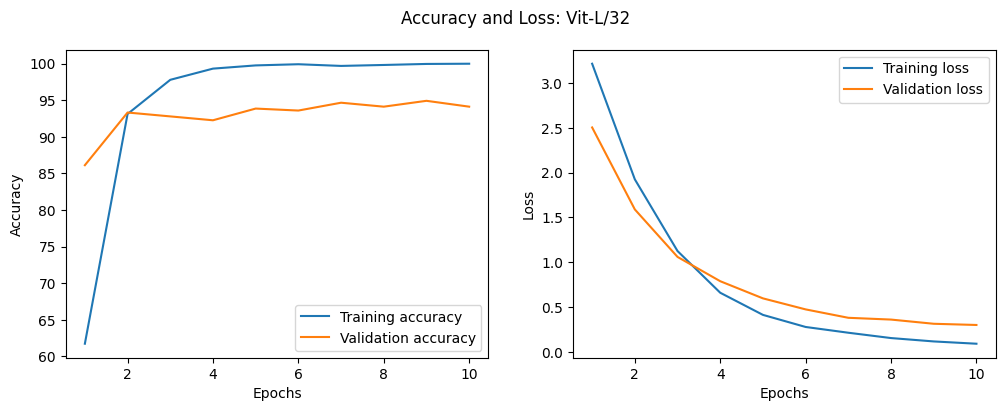

In [4]:
import matplotlib.pyplot as plt

# Extracted data
train_accuracies = [61.73, 93.13, 97.80, 99.33, 99.77, 99.93, 99.70, 99.83, 99.97, 100.00]
val_accuracies = [86.13, 93.33, 92.80, 92.27, 93.87, 93.60, 94.67, 94.13, 94.93, 94.13]
train_losses = [3.2142, 1.9250, 1.1258, 0.6609, 0.4141, 0.2793, 0.2151, 0.1557, 0.1181, 0.0926]
val_losses = [2.5037, 1.5896, 1.0602, 0.7895, 0.5982, 0.4753, 0.3816, 0.3618, 0.3150, 0.3016]

def plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training accuracy')
    plt.plot(epochs, val_accuracies, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle('Accuracy and Loss: Vit-L/32')
    plt.show()

plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)
